# Spam Filter Based on Naive Bayesian Classifier
FAIKR ProjectWork.

Author:
 - Samuele Marino

## Introduction

Nowadays we get dozens of spam messages every day unless you use well-trained filters. They may be harmful, just annoying or space-consuming, but they also can contain viruses or fishing attempts. In any case, it is not the content we want to deal with. So the demand for good spam filters is always high.

One of the pretty effective algorithms for spam filtering is Naive Bayes classification.


Most commonly used in email spam filtering, Naive Bayes can be used to classify many different kinds of documents.
A document is anything that is being classified by the filter. The class of a document in our case is very simple:
something will be classified as either spam or ham. Spam is an unwanted document and ham is a non-spam document.
All of the methods discussed here use supervised forms of machine learning. This means that the filter that is created
first needs to be trained by previously classified documents provided by the user. Essentially this means that you cannot
develop a filter and immediately implement it, because it will not have any basis for classifying a document as spam
or ham. But once you do train the filter, no more training is needed as each new document classified additionally trains
the filter by simply being classified. There are other implementations that are semi-supervised, where documents that
have not been explicitly classified can be used to classify further documents. But in the following models, all the documents 
that are classified or in the training data are classified as either spam or ham, are not using any semi-supervised techniques.

Two methods of Bayesian classification will be explored, those being Multinomial Bayes, and Multivariate Bayes that are modification of Naive Bayes.

Although there is already existing implementation in scikit-learn package, I want to recreate the algorithm from scratch: 
 - Firstly, I want to uncover the logic hidden behind the implementation.
 - Secondly, I want to show the algorithm in conjunction with the dataset preparation.

## Naive Bayes

Naive Bayes must be trained with controlled data that is already defined as spam or ham so the model can be applied to real world situations. Naive Bayes also assumes that the features that it is classifying, in our case the individual words of the email, are independent from one another and we count them with the ignorance of the context. Once the data is given, a filter is created that assigns the probability that each feature is in spam. 

Probabilities in this case are written as values between 0 and 1.

The following image represent the Bayesian Network and shows that the words are independent from each other in the classification of the email, and are all treated equally.

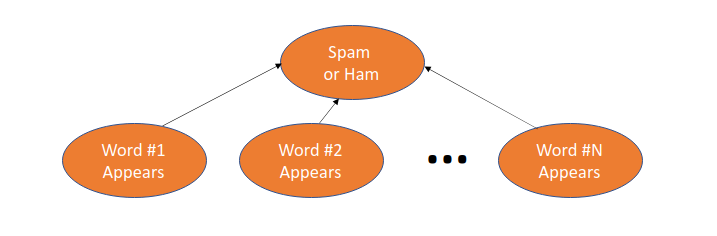

In order to label the document as either spam or ham we need to compute the probability than an email is spam or ham given that the words W are in the email, $P(S|W)$ and $P(H|W)$ respectively.

The probability that an email is spam given that the email contains the words W is
\begin{equation*}
P(S|W) = \frac{P(W|S)P(S)}{P(W)}
\end{equation*}
where:
\begin{equation*}
P(W|S)=P(w_1,w_2,...,w_n|S)=\prod_{i=1}^{n}P(w_i|S)
\end{equation*}
and
\begin{equation*}
P(W)=P(W|S)P(S)+P(W|H)P(H) 
\end{equation*}

$P(H|W)$ can be calculated similarly, so we can say that:
\begin{equation*}
P(S|W) \propto \prod_{i=1}^{n}P(w_i|S)P(S)
\end{equation*}
and 
\begin{equation*}
P(H|W) \propto \prod_{i=1}^{n}P(w_i|H)P(H)
\end{equation*}

There is the possibility that same probability is really small, so it's a good idea change the space to $log$ space to prevent underflow.

\begin{equation*}
\ln(P(S|W)) \propto \ln(\prod_{i=1}^{n}P(w_i|S)P(S)) = \ln(P(S)\prod_{i=1}^{n}P(w_i|S)) = \ln(P(S)) + \sum_{i=1}^{n}\ln(P(w_i|S))
\end{equation*}

The same operation can be applied to $P(H|W)$ 

## Multinomial Naive Bayes

Multinomial Naive Bayes keep track of the number of occurrences of each word. So for the following formulas W represents a multiset of words in the document. This means
that W also contains the correct number of occurrences of each word. We can assume that the words are generated following a multinomial distribution and are independent.
So we can compute $P(W|S)$.
\begin{equation*}
P(W|S) = \frac{N_{W,S} + \alpha}{N_S + \alpha N_V}
\end{equation*}

where:
- $N_V$ is the number of unique words in the whole dataset.
- $N_S$ is the total number of words in the spam messages.
- $N_{W,S}$ is the number of occurrences of the word $W$ in all spam messages.
- $\alpha$ is smoothing parameter. It prevents this value from being 0 if there are few occurrences of a particular word. In doing so it prevents our calculation from being highly inaccurate. It also prevents a divide-by-zero error.


Let's write some code...

### Import libraries

In [1]:
import pandas as pd
from math import log

### Dataset

I will use the collection of SMS messages, which was put together by Tiago A. Almeida and José María Gómez Hidalgo. It is free and can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

Dataset structure is simple. It contains two columns:
- one for the label “spam/ham”
- for the text of the message.

In [2]:
url = "Dataset/SMSSpamCollection"
sms_data = pd.read_csv(url, header=None, sep='\t', names=['Label', 'SMS'])

sms_data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms_data.groupby('Label').count()

,SMS
Label,
ham,4825
spam,747


It contains 5572 records of different messages together with 747 spam messages.

### Preparation

Before the algorithm application, I prepare data. First of all, I will remove the punctuation. Then I will convert all the text into the lower-case and split it into the separate words.

In [4]:
sms_data_clean = sms_data.copy()

In [ ]:
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.lower()
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.split()

In [6]:
sms_data_clean['SMS'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: SMS, dtype: object

#### Split to train and test data

In [7]:
train_data = sms_data_clean.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_data = sms_data_clean.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [8]:
print(f'The number of sample in the train data is: {train_data.shape[0]}')
train_data['Label'].value_counts() / train_data.shape[0] * 100

The number of sample in the train data is: 4458


ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [9]:
print(f'The number of sample in the test data is: {test_data.shape[0]}')
test_data['Label'].value_counts() / test_data.shape[0] * 100

The number of sample in the test data is: 1114


ham     86.983842
spam    13.016158
Name: Label, dtype: float64

In [10]:
test_data.head()

,Label,SMS
0,ham,"[aight, should, i, just, plan, to, come, up, l..."
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup..."
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,..."
3,ham,"[this, is, wishing, you, a, great, day, moji, ..."
4,ham,"[thanks, again, for, your, reply, today, when,..."


### Prepare vocabulary

I prepare the vocabulary and count the number of separate words in each message.

In [11]:
vocabulary = list(dict.fromkeys(train_data['SMS'].sum()))
print(f'The length of the vocabulary is: {len(vocabulary)}')

The length of the vocabulary is: 7783


#### Calculate frequencies of the words for each message

In [12]:
word_counts_per_sms = pd.DataFrame([
    [row[1].count(word) for word in vocabulary]
    for _, row in train_data.iterrows()], columns=vocabulary)


Concat the resulting table of words count to our train data:

In [13]:
train_data_multinomial = pd.concat([train_data.reset_index(), word_counts_per_sms], axis=1).iloc[:,1:]

In [14]:
train_data_multinomial.head()

,Label,SMS,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,"[yep, yep, yep, by, the, pretty, sculpture]",3,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculate values for the Bayes formula

In [35]:
alpha = 1
Nvoc = len(vocabulary)
Pspam = train_data['Label'].value_counts()['spam'] / train_data.shape[0]
Pham = train_data['Label'].value_counts()['ham'] / train_data.shape[0]
Nspam = train_data.loc[train_data['Label'] == 'spam', 'SMS'].apply(len).sum()
Nham = train_data.loc[train_data['Label'] == 'ham', 'SMS'].apply(len).sum()

To complete the formula we will define the functions to determine the probabilities of the given word to belong to spam and non-spam messages:

In [20]:
def p_w_spam(word):
    if word in train_data_multinomial.columns:
        Nwspam = train_data_multinomial.loc[train_data_multinomial['Label'] == 'spam', word].sum()
        return (Nwspam + alpha) / (Nspam + alpha*Nvoc)
    else:
        return 1


def p_w_ham(word):
    if word in train_data_multinomial.columns:
        Nwham = train_data_multinomial.loc[train_data_multinomial['Label'] == 'ham', word].sum()
        return (Nwham + alpha) / (Nham + alpha*Nvoc)
    else:
        return 1

#### Prepare the classificator

In [18]:
def log_classify(message):
    p_spam_given_message = log(Pspam)
    p_ham_given_message = log(Pham)
    for word in message:
        p_spam_given_message += log(p_w_spam(word))
        p_ham_given_message += log(p_w_ham(word))
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'


### Testing on the data test

In [36]:
test_data['predicted Multinomial'] = test_data['SMS'].apply(log_classify)

In [37]:
test_data.head()

,Label,SMS,predicted Multinomial,predicted Multivariate
0,ham,"[aight, should, i, just, plan, to, come, up, l...",ham,ham
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup...",ham,ham
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,...",spam,spam
3,ham,"[this, is, wishing, you, a, great, day, moji, ...",ham,ham
4,ham,"[thanks, again, for, your, reply, today, when,...",ham,ham


In [38]:
correct = (test_data['predicted Multinomial'] == test_data['Label']).sum() / test_data.shape[0] * 100
print(f'The correct prediction are {correct:.2f}%')

The correct prediction are 99.19%


Uncorrect Prediction

In [24]:
test_data.loc[test_data['predicted Multinomial'] != test_data['Label']]

,Label,SMS,predicted Multinomial
56,spam,"[money, i, have, won, wining, number, 946, wot...",ham
218,spam,"[hi, babe, its, chloe, how, r, u, i, was, smas...",ham
404,ham,"[nokia, phone, is, lovly]",spam
473,spam,"[hi, the, sexychat, girls, are, waiting, for, ...",ham
491,spam,"[hi, this, is, amy, we, will, be, sending, you...",ham
579,spam,"[you, won, t, believe, it, but, it, s, true, i...",ham
588,ham,"[we, have, sent, jd, for, customer, service, c...",spam
912,spam,"[dating, i, have, had, two, of, these, only, s...",ham


## Multivariate Naive Bayes

Multivariate Naive Bayes, also known as Bernoulli Naive Bayes is a method that is closely related to Multinomial Bayes. Similar to the multinomial approach, it treats each feature individually. This means that W contains either true(1) or false(0) for each word, instead of containing the counting of the words themselves. Note that Multivariate Bayes is still naive, so each feature is still independent from all other features. We can find the probabilities of the parameters in a similar fashion to Multinomial Bayes, resulting in the following equation:
\begin{equation*}
P(W|S) = \frac{1 + N_{W,S}}{2 + N_S}
\end{equation*}

where:
- $N_S$ is the total number of email that are classified as spam
- $N_{W,S}$ is the total number of training spam email that contain the word $W$
- 1 and 2 are smoothing parameter.

Multivariate Bayes does not keep track of the number of occurrences of features, unlike Multinomnial Bayes, which means that Multivariate Bayes scales better.

Let's modify the below implementation...

#### Calculate presences of the words for each message

In [25]:
word_presences_per_sms = pd.DataFrame([
    [1 if word in row[1] else 0 for word in vocabulary]
    for _, row in train_data.iterrows()], columns=vocabulary)


Concat the resulting table

In [26]:
train_data_multivariate = pd.concat([train_data.reset_index(), word_presences_per_sms], axis=1).iloc[:,1:]

In [27]:
train_data_multivariate.head()

,Label,SMS,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,"[yep, yep, yep, by, the, pretty, sculpture]",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rewrite probabilities of the given word to belong to spam and non-spam messages:

In [29]:
Ns = train_data_multinomial['Label'].value_counts()['spam']
Nh = train_data_multinomial['Label'].value_counts()['ham']

def p_w_spam_multivariate(word):
    if word in train_data_multinomial.columns:
        Nwspam = train_data_multinomial.loc[train_data_multinomial['Label'] == 'spam', word].sum() 
        return (1 + Nwspam) / (2 + Ns)
    else:
        return 1


def p_w_ham_multivariate(word):
    if word in train_data_multinomial.columns:
        Nwham = train_data_multinomial.loc[train_data_multinomial['Label'] == 'ham', word].sum()
        return (1 + Nwham) / (2 + Nh)
    else:
        return 1


### Modify the classificator

In [30]:
def log_classify_multivariate(message):
    message = dict.fromkeys(message)
    p_spam_given_message = log(Pspam)
    p_ham_given_message = log(Pham)
    for word in message:
        p_spam_given_message += log(p_w_spam_multivariate(word))
        p_ham_given_message += log(p_w_ham_multivariate(word))
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'


### Testing on the data test

In [31]:
test_data['predicted Multivariate'] = test_data['SMS'].apply(log_classify_multivariate)

In [32]:
test_data.head()

,Label,SMS,predicted Multinomial,predicted Multivariate
0,ham,"[aight, should, i, just, plan, to, come, up, l...",ham,ham
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup...",ham,ham
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,...",spam,spam
3,ham,"[this, is, wishing, you, a, great, day, moji, ...",ham,ham
4,ham,"[thanks, again, for, your, reply, today, when,...",ham,ham


In [33]:
correct = (test_data['predicted Multivariate'] == test_data['Label']).sum() / test_data.shape[0] * 100
print(f'The correct prediction are {correct:.2f}%')


The correct prediction are 87.97%


Uncorrect Prediction

In [34]:
test_data.loc[test_data['predicted Multivariate'] != test_data['Label']]

,Label,SMS,predicted Multinomial,predicted Multivariate
7,ham,"[ranjith, cal, drpd, deeraj, and, deepak, 5min...",ham,spam
8,ham,"[cheers, for, callin, babe, sozi, culdnt, talk...",ham,spam
20,ham,"[oh, only, 4, outside, players, allowed, to, p...",ham,spam
22,ham,"[erutupalam, thandiyachu]",ham,spam
30,ham,"[miss, call, miss, call, khelate, kintu, oppon...",ham,spam
...,...,...,...,...
1075,ham,"[hey, chief, can, you, give, me, a, bell, when...",ham,spam
1084,ham,"[armand, says, get, your, ass, over, to, epsilon]",ham,spam
1094,ham,"[have, a, safe, trip, to, nigeria, wish, you, ...",ham,spam
1095,ham,"[hahaha, use, your, brain, dear]",ham,spam


## Conclusion

Naive Bayes is a very simple algorithm that performs equally well against much more complex classifiers in many cases, and even occasionally outperforms them. It also does not classify the email on the basis of one or two words, but instead takes into account every single relevant word. Another benefit of Bayesian filtering is that it is constantly adapting to new forms of spam. One of the most significant disadvantages of Bayesian filtering is that the filter depends entirely upon the training data
that is provided by the user, which is classified into spam and ham prior to training the model.
In this particular field of application and using this dataset the Multinomial perform better then the Multivariate.